In [28]:
# BEFORE RUNNING THE CELLS, PLEASE GO TO "EDIT" -> "NOTEBOOK SETTINGS" -> AND SET "HARDWARE ACCELERATOR" TO GPU

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

import numpy as np 
import matplotlib.pyplot as plt 
import argparse
import os
import cv2 
import random

import sys
from PIL import Image

import pickle

import math

In [29]:
DATADIR = "./finaldata" 
CATEGORIES = ["Boring", "Interesting"]
training_data = []
IMG_SIZE = 300 # Hyperparameter. calculated to be stitched together size. each img is 396 x 396. Stitching them together 396*3 = 1188x 1188. So 1185 is an approximation of that.

In [105]:
def compute_entropy(file_path, file_name):
    res = []
    vector = []
    for i in range(80, 120): 
        IMAGE_DIR = file_path + "/" + file_name + str(i) + ".png"
        img_array = cv2.imread(IMAGE_DIR, cv2.IMREAD_GRAYSCALE) # img_array is a 2-d array
        vector.append(img_array)
    for i in range(len(vector) - 1): 
        vector_one, vector_two = vector[i], vector[i + 1] 
        entropy = sum([(vector_one[j] - vector_two[j])**2 for j in range(len(vector_one))])/len(vector_one)
        res.append(entropy)
    for i in range(len(res)): 
        res[i] = sum(res[i])/len(res[i])

In [106]:
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for image in sorted(os.listdir(path)):
        if ".png" not in image or "80" not in image:
            continue
        file_name = image[0:-6]
        compute_entropy(path, file_name)
        
compute_entropy("./finaldata/Interesting", "S_B2_States3_Interesting_Sample0_")

39


In [55]:
# The number of frames we use (e.g. 9) is a hyperparameter, but it has to be a square (4, 9, 16)
# The starting frame (e.g., 100) is another hyperparameter. If the size is 9, the frames we use would be in [100, 100 + 9)

def stitch_images(file_path, file_name, start_frame, num_frames, save_DIR):
    images = [Image.open(image) for image in [file_path + "/" + file_name + str(x) + ".png" for x in range(start_frame, start_frame + num_frames)]]
    widths, heights = zip(*(i.size for i in images))
    dimension = int(math.sqrt(num_frames))
    total_width = int(sum(widths) / dimension)
    total_height = int(sum(heights) / dimension)
    new_image = Image.new("RGB", (total_width, total_height))
    for index in range(0, num_frames):
        image = images[index]
        new_image.paste(image, ((index % dimension ) * image.size[0], math.floor(index / dimension) * image.size[1]))
    save_DIR = save_DIR + "combined_" + file_name + ".png"
    new_image.save(save_DIR)
    return save_DIR

In [64]:
def create_training_data():
    all_training_data = {} # dict containing training data for hyperparameter configs
    for category in CATEGORIES: 
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for image in sorted(os.listdir(path)): 
            if ".png" not in image:
                continue
            for start_frame in [80, 100]:
                if str(start_frame) not in image: ## Find the starting frame
                    continue
                for num_frames in [4, 9, 16]:
                    training_data = [] 
                    save_DIR = "./finaldata/" + category + "/combined_" + str(start_frame) + "_" + str(num_frames) + "/"                    
                    if start_frame < 100: 
                        file_name = image[0:-6]
                    else: 
                        file_name = image[0:-7]
                    if not os.path.isdir(save_DIR):
                        os.mkdir(save_DIR)
                    IMAGE_DIR = stitch_images(path, file_name, start_frame, num_frames, save_DIR)  # selecting the last 7 character of the file name 
                    # The following snippet to reduce data size
                    try: 
                        img_array = cv2.imread(IMAGE_DIR, cv2.IMREAD_GRAYSCALE) #cv2.IMREAD_GRAYSCALE: It specifies to load an image in grayscale mode. Alternatively, we can pass integer value 0 for this flag.
                        training_data.append([img_array, class_num])
                    except Exception as e: 
                        pass 
                    all_training_data[(start_frame, num_frames)] = training_data
    return all_training_data

In [65]:
all_training_data = create_training_data() 
for training_data in all_training_data.values():
    random.shuffle(training_data)

In [9]:
X, y = [], []
for features, label in training_data: 
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) # -1 automatically changes to the # of instances
y = np.array(y)

In [10]:
print(X.shape)

(2100, 300, 300, 1)


In [11]:
X = X.astype('float32')
X = X / 255.0

In [12]:
from PIL import Image 
def compute_entropy(signal):
    lensig = signal.size
    symset = list(set(signal))
    numsym = len(symset)
    propab = [np.size(signal[signal == i]) / (1.0 * lensig) for i in symset]
    entropy = np.sum([p * np.log2(1.0 / p) for p in propab])
    return entropy

#
test = X[1].ravel()
print(len(X[1].ravel()))
print(compute_entropy(test))


label_entropies = {'Boring': [], 'Interesting': []}
for i, instance in enumerate(X):
    instance_1d = instance.ravel()
    entropy = compute_entropy(instance_1d)
    label_id = y[i]
    if label_id == 0:
        label_entropies['Boring'].append(entropy)
    else:
        label_entropies['Interesting'].append(entropy)

90000
2.5246440467268747


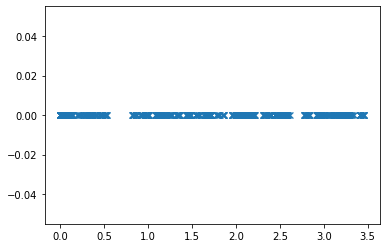

0.0


In [13]:
#label_entropies

import numpy as np
import matplotlib.pyplot as pp
val = 0. # this is the value where you want the data to appear on the y-axis.
ar = label_entropies['Boring'] # just as an example array
pp.plot(ar, np.zeros_like(ar) + val, 'x')
pp.show()
print(min(ar))

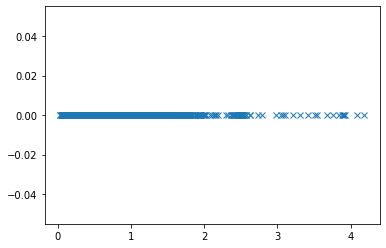

0.03183184025744431


In [14]:
#label_entropies

import numpy as np
import matplotlib.pyplot as pp
val = 0. # this is the value where you want the data to appear on the y-axis.
ar = label_entropies['Interesting'] # just as an example array
pp.plot(ar, np.zeros_like(ar) + val, 'x')
pp.show()

print(min(ar))

0.0
Baseline =  0.5
2100


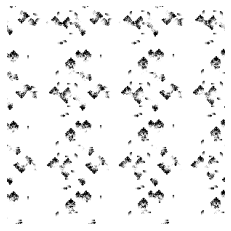

In [15]:
print(np.min(X))
plt.imshow(X[12].reshape(IMG_SIZE, IMG_SIZE), cmap='gray');
plt.axis('off')
plt.savefig('stitched_image.png')
print('Baseline = ', np.sum(y)/len(y) )
print(len(y))

In [16]:
# Split X, y into training and test data

print(X.shape)
print(X[:2000].shape)
tempx = X[:900]
tempy = y[:900]
X_train, X_test, y_train, y_test = train_test_split(tempx, tempy, test_size = 0.1, random_state = 42) 

(2100, 300, 300, 1)
(2000, 300, 300, 1)


In [23]:
# Train on training data only
model2 = keras.Sequential()
model2.add(Conv2D(64, (5, 5), input_shape=tempx.shape[1:]))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.15))

model2.add(Conv2D(64, (3, 3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.15))

model2.add(Flatten())
model2.add(Dense(64))
model2.add(Activation("relu"))
model2.add(Dropout(0.15))

model2.add(Dense(10))
model2.add(Activation("relu"))
model2.add(Dropout(0.15))

model2.add(Dense(1))
model2.add(Activation("sigmoid"))

model2.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

with tf.device('/device:GPU:0'):
    model2.fit(X_train, y_train, batch_size=2, epochs=20, verbose = 1) 

Epoch 1/20
405/405 [==============================] - 10s 21ms/step - loss: 30.6380 - accuracy: 0.5273
Epoch 2/20
405/405 [==============================] - 9s 21ms/step - loss: 5.2468 - accuracy: 0.5014
Epoch 3/20
405/405 [==============================] - 9s 21ms/step - loss: 1.9650 - accuracy: 0.5507
Epoch 4/20
405/405 [==============================] - 9s 21ms/step - loss: 1.3771 - accuracy: 0.5086
Epoch 5/20
405/405 [==============================] - 9s 21ms/step - loss: 1.7150 - accuracy: 0.5351
Epoch 6/20
405/405 [==============================] - 9s 21ms/step - loss: 0.9716 - accuracy: 0.5162
Epoch 7/20
405/405 [==============================] - 9s 21ms/step - loss: 1.6350 - accuracy: 0.4977
Epoch 8/20
405/405 [==============================] - 9s 21ms/step - loss: 0.7625 - accuracy: 0.5510
Epoch 9/20
405/405 [==============================] - 9s 21ms/step - loss: 0.7809 - accuracy: 0.5887
Epoch 10/20
405/405 [==============================] - 9s 21ms/step - loss: 0.7542 - accu

In [24]:
# Split X, y into training and test data
#X_train, X_test, y_train, y_test = train_test_split(tempx, tempy, test_size = 0.1, random_state = 42) 

# Reduce positive values to ~10% of data

# Find indices where y_test is interesting
y_test_bool = y_test == 1
num_true = 0
delete_mask = []
for i in range(0, len(y_test)):
  if y_test_bool[i] == True:
    num_true += 1
    if num_true > 15:
      delete_mask.append(i)
      

y_test = np.delete(y_test, delete_mask, 0)
X_test = np.delete(X_test, delete_mask, 0)
print(X_test.shape)
print(np.sum(y_test))

(56, 300, 300, 1)
15


In [25]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Do an accuracy test on data with only ~10% interesting claseses
print('Accuracy on test---')
y_pred_test=model2.predict_classes(X_test)
print(accuracy_score(y_test,y_pred_test))
print(recall_score(y_test,y_pred_test))

Accuracy on test---
0.8571428571428571
0.4666666666666667


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [32]:
# Split X, y into training and test data

print(X.shape)
print(X[:2000].shape)
tempx = X[:1200]
tempy = y[:1200]
X_train, X_test, y_train, y_test = train_test_split(tempx, tempy, test_size = 0.1, random_state = 42) 



(2100, 300, 300, 1)
(2000, 300, 300, 1)


In [33]:
# Train on training data only
model3 = keras.Sequential()
model3.add(Conv2D(64, (5, 5), input_shape=tempx.shape[1:]))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.15))

model3.add(Conv2D(64, (3, 3)))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.15))

model3.add(Flatten())
model3.add(Dense(64))
model3.add(Activation("relu"))
model3.add(Dropout(0.15))

model3.add(Dense(10))
model3.add(Activation("relu"))
model3.add(Dropout(0.15))

model3.add(Dense(1))
model3.add(Activation("sigmoid"))

model3.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

with tf.device('/device:GPU:0'):
  model3.fit(X_train, y_train, batch_size=2, epochs=20, verbose = 1) 

Epoch 1/20
540/540 [==============================] - 12s 21ms/step - loss: 13.1818 - accuracy: 0.4819
Epoch 2/20
540/540 [==============================] - 11s 21ms/step - loss: 4.1287 - accuracy: 0.4959
Epoch 3/20
540/540 [==============================] - 11s 21ms/step - loss: 2.7505 - accuracy: 0.5290
Epoch 4/20
540/540 [==============================] - 11s 21ms/step - loss: 2.0570 - accuracy: 0.5127
Epoch 5/20
540/540 [==============================] - 11s 21ms/step - loss: 1.1156 - accuracy: 0.5678
Epoch 6/20
540/540 [==============================] - 11s 21ms/step - loss: 0.8841 - accuracy: 0.6633
Epoch 7/20
540/540 [==============================] - 11s 21ms/step - loss: 0.7968 - accuracy: 0.6945
Epoch 8/20
540/540 [==============================] - 11s 21ms/step - loss: 0.8373 - accuracy: 0.7071
Epoch 9/20
540/540 [==============================] - 11s 21ms/step - loss: 0.7935 - accuracy: 0.7604
Epoch 10/20
540/540 [==============================] - 11s 21ms/step - loss: 0.57

In [35]:
# Split X, y into training and test data
#X_train, X_test, y_train, y_test = train_test_split(tempx, tempy, test_size = 0.1, random_state = 42) 

# Reduce positive values to ~10% of data

# Find indices where y_test is interesting
y_test_bool = y_test == 1
num_true = 0
delete_mask = []
for i in range(0, len(y_test)):
  if y_test_bool[i] == True:
    num_true += 1
    if num_true > 15:
      delete_mask.append(i)
      

y_test = np.delete(y_test, delete_mask, 0)
X_test = np.delete(X_test, delete_mask, 0)
print(X_test.shape)
print(np.sum(y_test))

(79, 300, 300, 1)
15


In [36]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Do an accuracy test on data with only ~10% interesting claseses
print('Accuracy on test---')
y_pred_test=model3.predict_classes(X_test)
print(accuracy_score(y_test,y_pred_test))
print(recall_score(y_test,y_pred_test))

Accuracy on test---


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.9240506329113924
0.6


In [37]:
# Split X, y into training and test data

print(X.shape)
print(X[:2000].shape)
tempx = X[:1500]
tempy = y[:1500]
X_train, X_test, y_train, y_test = train_test_split(tempx, tempy, test_size = 0.1, random_state = 42) 

(2100, 300, 300, 1)
(2000, 300, 300, 1)


In [38]:
# Train on training data only
model4 = keras.Sequential()
model4.add(Conv2D(64, (5, 5), input_shape=tempx.shape[1:]))
model4.add(BatchNormalization())
model4.add(Activation("relu"))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.15))

model4.add(Conv2D(64, (3, 3)))
model4.add(BatchNormalization())
model4.add(Activation("relu"))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.15))

model4.add(Flatten())
model4.add(Dense(64))
model4.add(Activation("relu"))
model4.add(Dropout(0.15))

model4.add(Dense(10))
model4.add(Activation("relu"))
model4.add(Dropout(0.15))

model4.add(Dense(1))
model4.add(Activation("sigmoid"))

model4.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

with tf.device('/device:GPU:0'):
  model4.fit(X_train, y_train, batch_size=2, epochs=20, verbose = 1) 

Epoch 1/20
675/675 [==============================] - 15s 21ms/step - loss: 20.1628 - accuracy: 0.5326
Epoch 2/20
675/675 [==============================] - 14s 21ms/step - loss: 1.9422 - accuracy: 0.5420
Epoch 3/20
675/675 [==============================] - 14s 21ms/step - loss: 1.4865 - accuracy: 0.6022
Epoch 4/20
675/675 [==============================] - 14s 21ms/step - loss: 0.8764 - accuracy: 0.5617
Epoch 5/20
675/675 [==============================] - 14s 21ms/step - loss: 0.8954 - accuracy: 0.6174
Epoch 6/20
675/675 [==============================] - 14s 21ms/step - loss: 0.8750 - accuracy: 0.6904
Epoch 7/20
675/675 [==============================] - 14s 21ms/step - loss: 0.5488 - accuracy: 0.7604
Epoch 8/20
675/675 [==============================] - 14s 21ms/step - loss: 0.4696 - accuracy: 0.7794
Epoch 9/20
675/675 [==============================] - 14s 21ms/step - loss: 0.5498 - accuracy: 0.7903
Epoch 10/20
675/675 [==============================] - 14s 21ms/step - loss: 0.39

In [39]:
# Split X, y into training and test data
#X_train, X_test, y_train, y_test = train_test_split(tempx, tempy, test_size = 0.1, random_state = 42) 

# Reduce positive values to ~10% of data

# Find indices where y_test is interesting
y_test_bool = y_test == 1
num_true = 0
delete_mask = []
for i in range(0, len(y_test)):
  if y_test_bool[i] == True:
    num_true += 1
    if num_true > 15:
      delete_mask.append(i)
      

y_test = np.delete(y_test, delete_mask, 0)
X_test = np.delete(X_test, delete_mask, 0)
print(X_test.shape)
print(np.sum(y_test))

(84, 300, 300, 1)
15


In [40]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Do an accuracy test on data with only ~10% interesting claseses
print('Accuracy on test---')
y_pred_test=model4.predict_classes(X_test)
print(accuracy_score(y_test,y_pred_test))
print(recall_score(y_test,y_pred_test))

Accuracy on test---


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.8690476190476191
1.0


In [41]:
# Split X, y into training and test data

print(X.shape)
print(X[:2000].shape)
tempx = X[:1800]
tempy = y[:1800]
X_train, X_test, y_train, y_test = train_test_split(tempx, tempy, test_size = 0.1, random_state = 42) 

(2100, 300, 300, 1)
(2000, 300, 300, 1)


In [42]:
# Train on training data only
model5 = keras.Sequential()
model5.add(Conv2D(64, (5, 5), input_shape=tempx.shape[1:]))
model5.add(BatchNormalization())
model5.add(Activation("relu"))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.15))

model5.add(Conv2D(64, (3, 3)))
model5.add(BatchNormalization())
model5.add(Activation("relu"))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.15))

model5.add(Flatten())
model5.add(Dense(64))
model5.add(Activation("relu"))
model5.add(Dropout(0.15))

model5.add(Dense(10))
model5.add(Activation("relu"))
model5.add(Dropout(0.15))

model5.add(Dense(1))
model5.add(Activation("sigmoid"))

model5.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

with tf.device('/device:GPU:0'):
  model5.fit(X_train, y_train, batch_size=2, epochs=20, verbose = 1) 

Epoch 1/20
810/810 [==============================] - 18s 21ms/step - loss: 11.0010 - accuracy: 0.5661
Epoch 2/20
810/810 [==============================] - 17s 21ms/step - loss: 2.3966 - accuracy: 0.5348
Epoch 3/20
810/810 [==============================] - 17s 21ms/step - loss: 1.1856 - accuracy: 0.5358
Epoch 4/20
810/810 [==============================] - 17s 21ms/step - loss: 1.1256 - accuracy: 0.5609
Epoch 5/20
810/810 [==============================] - 17s 21ms/step - loss: 2.4789 - accuracy: 0.6955
Epoch 6/20
810/810 [==============================] - 17s 21ms/step - loss: 1.0624 - accuracy: 0.7428
Epoch 7/20
810/810 [==============================] - 17s 21ms/step - loss: 1.2958 - accuracy: 0.7789
Epoch 8/20
810/810 [==============================] - 17s 21ms/step - loss: 1.1419 - accuracy: 0.7959
Epoch 9/20
810/810 [==============================] - 17s 21ms/step - loss: 2.1445 - accuracy: 0.8000
Epoch 10/20
810/810 [==============================] - 17s 21ms/step - loss: 1.39

In [43]:
# Split X, y into training and test data
#X_train, X_test, y_train, y_test = train_test_split(tempx, tempy, test_size = 0.1, random_state = 42) 

# Reduce positive values to ~10% of data

# Find indices where y_test is interesting
y_test_bool = y_test == 1
num_true = 0
delete_mask = []
for i in range(0, len(y_test)):
  if y_test_bool[i] == True:
    num_true += 1
    if num_true > 15:
      delete_mask.append(i)
      

y_test = np.delete(y_test, delete_mask, 0)
X_test = np.delete(X_test, delete_mask, 0)
print(X_test.shape)
print(np.sum(y_test))

(107, 300, 300, 1)
15


In [44]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Do an accuracy test on data with only ~10% interesting claseses
print('Accuracy on test---')
y_pred_test=model5.predict_classes(X_test)
print(accuracy_score(y_test,y_pred_test))
print(recall_score(y_test,y_pred_test))

Accuracy on test---


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.897196261682243
1.0


In [52]:
# Split X, y into training and test data

print(X.shape)
print(X[:2000].shape)
tempx = X[:2100]
tempy = y[:2100]
X_train, X_test, y_train, y_test = train_test_split(tempx, tempy, test_size = 0.1, random_state = 42) 

(2100, 300, 300, 1)
(2000, 300, 300, 1)


In [53]:
# Train on training data only
model6 = keras.Sequential()
model6.add(Conv2D(64, (5, 5), input_shape=tempx.shape[1:]))
model6.add(BatchNormalization())
model6.add(Activation("relu"))
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(Dropout(0.15))

model6.add(Conv2D(64, (3, 3)))
model6.add(BatchNormalization())
model6.add(Activation("relu"))
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(Dropout(0.15))

model6.add(Flatten())
model6.add(Dense(64))
model6.add(Activation("relu"))
model6.add(Dropout(0.15))

model6.add(Dense(10))
model6.add(Activation("relu"))
model6.add(Dropout(0.15))

model6.add(Dense(1))
model6.add(Activation("sigmoid"))

model6.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

with tf.device('/device:GPU:0'):
  model6.fit(X_train, y_train, batch_size=2, epochs=20, verbose = 1) 

Epoch 1/20
945/945 [==============================] - 21s 21ms/step - loss: 17.6165 - accuracy: 0.5648
Epoch 2/20
945/945 [==============================] - 20s 21ms/step - loss: 1.6180 - accuracy: 0.5159
Epoch 3/20
945/945 [==============================] - 20s 21ms/step - loss: 1.1564 - accuracy: 0.7608
Epoch 4/20
945/945 [==============================] - 20s 21ms/step - loss: 0.7761 - accuracy: 0.7565
Epoch 5/20
945/945 [==============================] - 20s 21ms/step - loss: 0.7098 - accuracy: 0.7684
Epoch 6/20
945/945 [==============================] - 20s 21ms/step - loss: 0.7201 - accuracy: 0.7847
Epoch 7/20
945/945 [==============================] - 20s 21ms/step - loss: 0.7381 - accuracy: 0.7940
Epoch 8/20
945/945 [==============================] - 20s 21ms/step - loss: 0.6300 - accuracy: 0.7828
Epoch 9/20
945/945 [==============================] - 20s 21ms/step - loss: 0.8615 - accuracy: 0.8036
Epoch 10/20
945/945 [==============================] - 20s 21ms/step - loss: 0.71

In [56]:
# Split X, y into training and test data
#X_train, X_test, y_train, y_test = train_test_split(tempx, tempy, test_size = 0.1, random_state = 42) 

# Reduce positive values to ~10% of data

# Find indices where y_test is interesting
y_test_bool = y_test == 1
num_true = 0
delete_mask = []
for i in range(0, len(y_test)):
  if y_test_bool[i] == True:
    num_true += 1
    if num_true > 15:
      delete_mask.append(i)
      

y_test = np.delete(y_test, delete_mask, 0)
X_test = np.delete(X_test, delete_mask, 0)
print(X_test.shape)
print(np.sum(y_test))

(123, 300, 300, 1)
15


In [57]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Do an accuracy test on data with only ~10% interesting claseses
print('Accuracy on test---')
y_pred_test=model6.predict_classes(X_test)
print(accuracy_score(y_test,y_pred_test))
print(recall_score(y_test,y_pred_test))

Accuracy on test---


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.8455284552845529
0.0
